### Import Libraries

In [56]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import xgboost as xgb
# import copy
# import gc
# import math
# import pickle

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll.base import scope
from sklearn.base import clone
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, QuantileTransformer, PowerTransformer
from scipy.stats import uniform, randint
from xgboost import XGBClassifier

import warnings 
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
start_time = time.time()

### Data Loading

In [19]:
train_df = pd.read_csv('train.csv', index_col='id')
test_df = pd.read_csv('test.csv', index_col='id')
# train_data['is_train'] = 1
# test_data['is_train'] = 0

# Combine train and test data for processing
# combined_df = pd.concat([train_data, test_data])
# del train_data, test_data

In [20]:
train_df.head()

Gender  Age  Driving_License  Region_Code  Previously_Insured Vehicle_Age  \
id                                                                              
0     Male   21                1         35.0                   0    1-2 Year   
1     Male   43                1         28.0                   0   > 2 Years   
2   Female   25                1         14.0                   1    < 1 Year   
3   Female   35                1          1.0                   0    1-2 Year   
4   Female   36                1         15.0                   1    1-2 Year   

   Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  Response  
id                                                                          
0             Yes         65101.0                 124.0      187         0  
1             Yes         58911.0                  26.0      288         1  
2              No         38043.0                 152.0      254         0  
3             Yes          2630.0                 156.0       76         0  
4              No         31951.0                 152.0      294         0

In [21]:
test_df.head()

Gender  Age  Driving_License  Region_Code  Previously_Insured  \
id                                                                        
11504798  Female   20                1         47.0                   0   
11504799    Male   47                1         28.0                   0   
11504800    Male   47                1         43.0                   0   
11504801  Female   22                1         47.0                   1   
11504802    Male   51                1         19.0                   0   

         Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  \
id                                                                          
11504798    < 1 Year             No          2630.0                 160.0   
11504799    1-2 Year            Yes         37483.0                 124.0   
11504800    1-2 Year            Yes          2630.0                  26.0   
11504801    < 1 Year             No         24502.0                 152.0   
11504802    1-2 Year             No         34115.0                 124.0   

          Vintage  
id                 
11504798      228  
11504799      123  
11504800      271  
11504801      115  
11504802      148

### Data Processing

In [22]:
train_df.duplicated().sum()

0

In [23]:
test_df.duplicated().sum()

0

In [24]:
train_df.isnull().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [25]:
test_df.isnull().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64

In [26]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11504798 entries, 0 to 11504797
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Gender                object 
 1   Age                   int64  
 2   Driving_License       int64  
 3   Region_Code           float64
 4   Previously_Insured    int64  
 5   Vehicle_Age           object 
 6   Vehicle_Damage        object 
 7   Annual_Premium        float64
 8   Policy_Sales_Channel  float64
 9   Vintage               int64  
 10  Response              int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 1.0+ GB


In [27]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7669866 entries, 11504798 to 19174663
Data columns (total 10 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Gender                object 
 1   Age                   int64  
 2   Driving_License       int64  
 3   Region_Code           float64
 4   Previously_Insured    int64  
 5   Vehicle_Age           object 
 6   Vehicle_Damage        object 
 7   Annual_Premium        float64
 8   Policy_Sales_Channel  float64
 9   Vintage               int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 643.7+ MB


In [28]:
column_names = train_df.columns.tolist()

for i in column_names:
    print(i, train_df[i].nunique(), 'unique values')

Gender 2 unique values
Age 66 unique values
Driving_License 2 unique values
Region_Code 54 unique values
Previously_Insured 2 unique values
Vehicle_Age 3 unique values
Vehicle_Damage 2 unique values
Annual_Premium 51728 unique values
Policy_Sales_Channel 152 unique values
Vintage 290 unique values
Response 2 unique values


### Split the data into train and validation

In [29]:
# Since we have only one data set, spliting it into train and test (validation)

raw_train_df, validation_df = train_test_split(train_df, train_size = 0.75, random_state = 1, stratify = train_df['Response'])

logger.info(f"Data split completed. Time elapsed: {time.time() - start_time:.2f} seconds")

raw_train_df.head(2)

INFO:__main__:Data split completed. Time elapsed: 35.65 seconds


Gender  Age  Driving_License  Region_Code  Previously_Insured  \
id                                                                       
6400262  Female   26                1         28.0                   0   
8095698  Female   25                1         30.0                   1   

        Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  \
id                                                                         
6400262    < 1 Year             No         54497.0                  26.0   
8095698    < 1 Year             No         38748.0                 152.0   

         Vintage  Response  
id                          
6400262      234         0  
8095698      131         0

In [30]:
validation_df.head(2)

Gender  Age  Driving_License  Region_Code  Previously_Insured  \
id                                                                       
6517611    Male   44                1         28.0                   0   
1591313  Female   23                1         14.0                   1   

        Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  \
id                                                                         
6517611    1-2 Year            Yes          2630.0                 157.0   
1591313    < 1 Year             No         35345.0                 152.0   

         Vintage  Response  
id                          
6517611       91         0  
1591313      272         0

In [31]:
raw_train_df.shape

(8628598, 11)

In [32]:
validation_df.shape

(2876200, 11)

In [33]:
def transform_categorical_features(df):
    gender_map = {'Male': 0, 'Female': 1}
    vehicle_age_map = {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}
    vehicle_damage_map = {'No': 0, 'Yes': 1}
    
    df['Gender'] = df['Gender'].map(gender_map)
    df['Vehicle_Age'] = df['Vehicle_Age'].map(vehicle_age_map)
    df['Vehicle_Damage'] = df['Vehicle_Damage'].map(vehicle_damage_map)
    
    return df

def adjust_data_types(df):
    df['Region_Code'] = df['Region_Code'].astype(int)
    df['Annual_Premium'] = df['Annual_Premium'].astype(int)
    df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype(int)
    
    return df

def create_additional_features(df):
    df['Prev_Insured_Annual_Premium'] = pd.factorize(df['Previously_Insured'].astype(str) + df['Annual_Premium'].astype(str))[0]
    df['Prev_Insured_Vehicle_Age'] = pd.factorize(df['Previously_Insured'].astype(str) + df['Vehicle_Age'].astype(str))[0]
    df['Prev_Insured_Vehicle_Damage'] = pd.factorize(df['Previously_Insured'].astype(str) + df['Vehicle_Damage'].astype(str))[0]
    df['Prev_Insured_Vintage'] = pd.factorize(df['Previously_Insured'].astype(str) + df['Vintage'].astype(str))[0]
    
    return df

def optimize_memory_usage(df):
    start_mem_usage = df.memory_usage().sum() / 1024 ** 2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type.name in ['category', 'object']:
            raise ValueError(f"Column '{col}' is of type '{col_type.name}'")

        c_min = df[col].min()
        c_max = df[col].max()
        
        if str(col_type)[:3] == 'int':
            
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
                
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
                
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
                
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                df[col] = df[col].astype(np.int64)
        
        else:
        
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            
            else:
                df[col] = df[col].astype(np.float64)

    end_mem_usage = df.memory_usage().sum() / 1024**2
    print(f'------ Memory usage before: {start_mem_usage:.2f} MB')
    print(f'------ Memory usage after: {end_mem_usage:.2f} MB')
    print(f'------ Reduced memory usage by {(100 * (start_mem_usage - end_mem_usage) / start_mem_usage):.1f}%')
    print('**********************' * 5)

    return df

def apply_scaling(df, scaler_type, columns):

    if scaler_type == 'S':
        scaler = StandardScaler() 
    
    elif scaler_type == 'M':
        scaler = MinMaxScaler()  
    
    elif scaler_type == 'R':
        scaler = RobustScaler()  
    
    elif scaler_type == 'A':
        scaler = MaxAbsScaler() 
    
    elif scaler_type == 'Q':
        scaler = QuantileTransformer(output_distribution='normal') 
    
    elif scaler_type == 'P':
        scaler = PowerTransformer() 
    
    else:
        raise ValueError("Invalid scaler type. Choose 'S' for StandardScaler, 'M' for MinMaxScaler, 'R' for RobustScaler, 'A' for MaxAbsScaler,'Q' for QuantileTransformer, or 'P' for PowerTransformer.")

    scaled_data = df.copy()

    for col in columns:
        scaled_data[col] = scaler.fit_transform(scaled_data[[col]])

    return scaled_data


In [34]:
train_df = transform_categorical_features(train_df)
validation_df = transform_categorical_features(validation_df)
test_df = transform_categorical_features(test_df)

train_df = adjust_data_types(train_df)
validation_df = adjust_data_types(validation_df)
test_df = adjust_data_types(test_df)

train_df = create_additional_features(train_df)
validation_df = create_additional_features(validation_df)
test_df = create_additional_features(test_df)

train_df = optimize_memory_usage(train_df)
validation_df = optimize_memory_usage(validation_df)
test_df = optimize_memory_usage(test_df)

------ Memory usage before: 1272.73 MB
------ Memory usage after: 351.10 MB
------ Reduced memory usage by 72.4%
**************************************************************************************************************
------ Memory usage before: 318.18 MB
------ Memory usage after: 87.77 MB
------ Reduced memory usage by 72.4%
**************************************************************************************************************
------ Memory usage before: 789.97 MB
------ Memory usage after: 226.75 MB
------ Reduced memory usage by 71.3%
**************************************************************************************************************


In [35]:
train_df.head(2)

Gender  Age  Driving_License  Region_Code  Previously_Insured  \
id                                                                  
0        0   21                1           35                   0   
1        0   43                1           28                   0   

    Vehicle_Age  Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  \
id                                                                      
0             1               1           65101                   124   
1             2               1           58911                    26   

    Vintage  Response  Prev_Insured_Annual_Premium  Prev_Insured_Vehicle_Age  \
id                                                                             
0       187         0                            0                         0   
1       288         1                            1                         1   

    Prev_Insured_Vehicle_Damage  Prev_Insured_Vintage  
id                                                     
0                             0                     0  
1                             0                     1

In [36]:
validation_df.head(2)

Gender  Age  Driving_License  Region_Code  Previously_Insured  \
id                                                                       
6517611       0   44                1           28                   0   
1591313       1   23                1           14                   1   

         Vehicle_Age  Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  \
id                                                                           
6517611            1               1            2630                   157   
1591313            0               0           35345                   152   

         Vintage  Response  Prev_Insured_Annual_Premium  \
id                                                        
6517611       91         0                            0   
1591313      272         0                            1   

         Prev_Insured_Vehicle_Age  Prev_Insured_Vehicle_Damage  \
id                                                               
6517611                         0                            0   
1591313                         1                            1   

         Prev_Insured_Vintage  
id                             
6517611                     0  
1591313                     1

In [37]:
test_df.head(2)

Gender  Age  Driving_License  Region_Code  Previously_Insured  \
id                                                                        
11504798       1   20                1           47                   0   
11504799       0   47                1           28                   0   

          Vehicle_Age  Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  \
id                                                                            
11504798            0               0            2630                   160   
11504799            1               1           37483                   124   

          Vintage  Prev_Insured_Annual_Premium  Prev_Insured_Vehicle_Age  \
id                                                                         
11504798      228                            0                         0   
11504799      123                            1                         1   

          Prev_Insured_Vehicle_Damage  Prev_Insured_Vintage  
id                                                           
11504798                            0                     0  
11504799                            1                     1

In [38]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11504798 entries, 0 to 11504797
Data columns (total 15 columns):
 #   Column                       Dtype
---  ------                       -----
 0   Gender                       int8 
 1   Age                          int8 
 2   Driving_License              int8 
 3   Region_Code                  int8 
 4   Previously_Insured           int8 
 5   Vehicle_Age                  int8 
 6   Vehicle_Damage               int8 
 7   Annual_Premium               int32
 8   Policy_Sales_Channel         int16
 9   Vintage                      int16
 10  Response                     int8 
 11  Prev_Insured_Annual_Premium  int32
 12  Prev_Insured_Vehicle_Age     int8 
 13  Prev_Insured_Vehicle_Damage  int8 
 14  Prev_Insured_Vintage         int16
dtypes: int16(3), int32(2), int8(10)
memory usage: 351.1 MB


In [39]:
train_df.describe()

Gender           Age  Driving_License   Region_Code  \
count  1.150480e+07  1.150480e+07     1.150480e+07  1.150480e+07   
mean   4.586490e-01  3.838356e+01     9.980220e-01  2.641869e+01   
std    4.982872e-01  1.499346e+01     4.443120e-02  1.299159e+01   
min    0.000000e+00  2.000000e+01     0.000000e+00  0.000000e+00   
25%    0.000000e+00  2.400000e+01     1.000000e+00  1.500000e+01   
50%    0.000000e+00  3.600000e+01     1.000000e+00  2.800000e+01   
75%    1.000000e+00  4.900000e+01     1.000000e+00  3.500000e+01   
max    1.000000e+00  8.500000e+01     1.000000e+00  5.200000e+01   

       Previously_Insured   Vehicle_Age  Vehicle_Damage  Annual_Premium  \
count        1.150480e+07  1.150480e+07    1.150480e+07    1.150480e+07   
mean         4.629966e-01  6.031073e-01    5.026798e-01    3.046137e+04   
std          4.986289e-01  5.678559e-01    4.999928e-01    1.645475e+04   
min          0.000000e+00  0.000000e+00    0.000000e+00    2.630000e+03   
25%          0.000000e+00  0.000000e+00    0.000000e+00    2.527700e+04   
50%          0.000000e+00  1.000000e+00    1.000000e+00    3.182400e+04   
75%          1.000000e+00  1.000000e+00    1.000000e+00    3.945100e+04   
max          1.000000e+00  2.000000e+00    1.000000e+00    5.401650e+05   

       Policy_Sales_Channel       Vintage      Response  \
count          1.150480e+07  1.150480e+07  1.150480e+07   
mean           1.124254e+02  1.638977e+02  1.229973e-01   
std            5.403571e+01  7.997953e+01  3.284341e-01   
min            1.000000e+00  1.000000e+01  0.000000e+00   
25%            2.900000e+01  9.900000e+01  0.000000e+00   
50%            1.510000e+02  1.660000e+02  0.000000e+00   
75%            1.520000e+02  2.320000e+02  0.000000e+00   
max            1.630000e+02  2.990000e+02  1.000000e+00   

       Prev_Insured_Annual_Premium  Prev_Insured_Vehicle_Age  \
count                 1.150480e+07              1.150480e+07   
mean                  1.669780e+04              1.703356e+00   
std                   1.796723e+04              1.450295e+00   
min                   0.000000e+00              0.000000e+00   
25%                   1.860000e+03              0.000000e+00   
50%                   1.075200e+04              2.000000e+00   
75%                   2.594800e+04              3.000000e+00   
max                   9.536900e+04              5.000000e+00   

       Prev_Insured_Vehicle_Damage  Prev_Insured_Vintage  
count                 1.150480e+07          1.150480e+07  
mean                  6.286911e-01          2.637749e+02  
std                   7.044007e-01          1.623910e+02  
min                   0.000000e+00          0.000000e+00  
25%                   0.000000e+00          1.230000e+02  
50%                   1.000000e+00          2.550000e+02  
75%                   1.000000e+00          3.960000e+02  
max                   3.000000e+00          5.790000e+02

In [40]:
scaler_type = 'S'
columns_to_scale_xgb = ['Age', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage','Prev_Insured_Annual_Premium', 'Prev_Insured_Vintage']

# Trying with Standard Scaler

train_df = apply_scaling(train_df, scaler_type, columns_to_scale_xgb)
validation_df = apply_scaling(validation_df, scaler_type, columns_to_scale_xgb)
test_df = apply_scaling(test_df, scaler_type, columns_to_scale_xgb)

logger.info(f"Data scaling completed. Time elapsed: {time.time() - start_time:.2f} seconds")

train_df.head(2)

INFO:__main__:Data scaling completed. Time elapsed: 113.39 seconds


Gender       Age  Driving_License  Region_Code  Previously_Insured  \
id                                                                       
0        0 -1.159410                1           35                   0   
1        0  0.307897                1           28                   0   

    Vehicle_Age  Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  \
id                                                                      
0             1               1        2.105145              0.214202   
1             2               1        1.728962             -1.599414   

     Vintage  Response  Prev_Insured_Annual_Premium  Prev_Insured_Vehicle_Age  \
id                                                                              
0   0.288852         0                    -0.929348                         0   
1   1.551675         1                    -0.929292                         1   

    Prev_Insured_Vehicle_Damage  Prev_Insured_Vintage  
id                                                     
0                             0             -1.624320  
1                             0             -1.618162

In [41]:
validation_df.head(2)

Gender       Age  Driving_License  Region_Code  Previously_Insured  \
id                                                                            
6517611       0  0.375931                1           28                   0   
1591313       1 -1.025614                1           14                   1   

         Vehicle_Age  Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  \
id                                                                           
6517611            1               1       -1.688222              0.824496   
1591313            0               0        0.296346              0.731953   

          Vintage  Response  Prev_Insured_Annual_Premium  \
id                                                         
6517611 -0.911745         0                    -0.939053   
1591313  1.351211         0                    -0.938996   

         Prev_Insured_Vehicle_Age  Prev_Insured_Vehicle_Damage  \
id                                                               
6517611                         0                            0   
1591313                         1                            1   

         Prev_Insured_Vintage  
id                             
6517611             -1.664407  
1591313             -1.658269

In [42]:
test_df.head(2)

Gender       Age  Driving_License  Region_Code  Previously_Insured  \
id                                                                             
11504798       1 -1.226132                1           47                   0   
11504799       0  0.573928                1           28                   0   

          Vehicle_Age  Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  \
id                                                                            
11504798            0               0       -1.692555              0.880929   
11504799            1               1        0.426701              0.215170   

           Vintage  Prev_Insured_Annual_Premium  Prev_Insured_Vehicle_Age  \
id                                                                          
11504798  0.801411                    -0.929854                         0   
11504799 -0.511344                    -0.929798                         1   

          Prev_Insured_Vehicle_Damage  Prev_Insured_Vintage  
id                                                           
11504798                            0             -1.613145  
11504799                            1             -1.607013

In [43]:
# TARGET = 'Response'
# FOLDS = 5
# SEED = 94
# ES_ROUNDS = 200
# LOG_STEPS = 500

In [44]:
# Ensure the target variable is of integer type

train_df['Response'] = train_df['Response'].astype(int)
validation_df['Response'] = validation_df['Response'].astype(int)

### Splitting dependent and independent variable

In [45]:
# Splitting dependent and independent variable

scaled_x_train = train_df.drop(['Response'], axis = 1)
scaled_y_train = train_df['Response']

scaled_x_val = validation_df.drop(['Response'], axis = 1)
scaled_y_val = validation_df['Response']

# Model training and evaluation

In [46]:
# def train_and_evaluate(model, X, y, X_test, folds=5, random_state=94):
#     print(f'Training {model.__class__.__name__}\n')
    
#     scores = []
#     feature_importances = np.zeros(X.shape[1])
#     evaluation_history = []
    
#     oof_pred_probs = np.zeros(X.shape[0])
#     test_pred_probs = np.zeros(X_test.shape[0])
    
#     skf = StratifiedKFold(n_splits=FOLDS, random_state=94, shuffle=True)
    
#     for fold_index, (train_index, val_index) in enumerate(skf.split(X, y)):
#         X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#         y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
#         model_clone = copy.deepcopy(model)
#         model_clone.fit(
#                 X_train, 
#                 y_train, 
#                 eval_set=[(X_val, y_val)], 
#                 verbose=500)
        
#         feature_importances += model_clone.feature_importances_ / folds
#         evaluation_history.append(model_clone.evals_result())
        
#         y_pred_probs = model_clone.predict_proba(X_val)[:, 1]
#         oof_pred_probs[val_index] = y_pred_probs
        
#         temp_test_pred_probs = model_clone.predict_proba(X_test)[:, 1]
#         test_pred_probs += temp_test_pred_probs / folds
        
#         auc_score = roc_auc_score(y_val, y_pred_probs)
#         scores.append(auc_score)
        
#         print(f'\n--- Fold {fold_index + 1} - AUC: {auc_score:.5f}\n\n')
        
#         del model_clone
#         gc.collect()
    
#     print(f'------ Average AUC: {np.mean(scores):.5f} ± {np.std(scores):.5f}\n\n')

#     return oof_pred_probs, test_pred_probs
# X_test = X_test.drop(columns=['Response'])

In [47]:
# best_params = {
#     'alpha': 1.302348865795227e-06, 
#     'max_depth': 15, 
#     'learning_rate': 0.061800451723613786, 
#     'subsample': 0.7098803046786328, 
#     'colsample_bytree': 0.2590672912533101, 
#     'min_child_weight': 10, 
#     'gamma': 0.8399887056014855, 
#     'reg_alpha': 0.0016943548302122801, 
#     'max_bin': 71284,
#     'early_stopping_rounds': 50
# }
# best_xgb_model = XGBClassifier(**best_params, n_estimators=12000, random_state=94, eval_metric="auc", device="cuda")


In [48]:
# # xgb_params = {
# #     'alpha': 1.302348865795227e-06, 
# #     'max_depth': 15, 
# #     'learning_rate': 0.061800451723613786, 
# #     'subsample': 0.7098803046786328, 
# #     'colsample_bytree': 0.2590672912533101, 
# #     'min_child_weight': 10, 
# #     'gamma': 0.8399887056014855, 
# #     'reg_alpha': 0.0016943548302122801, 
# #     'max_bin': 71284,
# #     'tree_method': 'gpu_hist', # Use GPU acceleration
# #     'colsample_bylevel': 0.21416299403295808,
# #     'colsample_bynode': 0.6208356380953189,
# #     'colsample_bytree': 0.19219680400212635,
# #     'gamma': 0.6051664515971382,
# #     'max_bin': 682,
# #     'max_delta_step': 5.264818337431145,
# #     'max_depth': 68,
# #     'min_child_weight': 5.23408291542125,
# #     'n_estimators': 10000,
# #     'n_jobs': -1,
# #     'objective': "binary:logistic",
# #     'random_state': SEED,
# #     'reg_alpha': 0.46516016901463414,
# #     'reg_lambda': 0.8410553418334902,
# #     'subsample': 0.802533192662325,
# #     'verbosity': 0,
# #     'eval_metric': "auc",
# #     'early_stopping_rounds': ES_ROUNDS,
# #     'tree_method': 'gpu_hist'  # Use GPU acceleration
    
# # }

# # xgb_model = XGBClassifier(**xgb_params)
# # Call train_and_evaluate function with XGBClassifier model
# oof_pred_probs, test_pred_probs = train_and_evaluate(best_xgb_model, X, y, X_test, folds=FOLDS, random_state=SEED)

In [49]:
# Fitting 5 folds for each of 1594323 candidates, totalling 7971615 fits
# Assuming an average time per fit, let's calculate:
# Average Time per Fit: Suppose each fit takes about 1 minute (60 seconds). This is a rough estimate and can vary.
# Total Time: Total Time = Number of Fits × Average Time per Fit
# Total Time = 7,971,615 × 60 seconds
# Total Time≈478,296,900 seconds
# Total Time≈5,535 days
# This number is impractically large, indicating that either the time per fit is too high or the hyperparameter space 
# needs to be reduced.
# # Define parameter grid

# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0],
#     'gamma': [0, 0.1, 0.2],
#     'min_child_weight': [1, 3, 5],
#     'reg_alpha': [0, 0.01, 0.1],
#     'reg_lambda': [1, 1.5, 2],
#     'scale_pos_weight': [1, 2, 3],
#     'max_delta_step': [0, 1, 2],
#     'colsample_bylevel': [0.8, 0.9, 1.0],
#     'colsample_bynode': [0.8, 0.9, 1.0],
#     'n_jobs': [-1],  # Use all available cores
#     'objective': ['binary:logistic']
# }

# # Create XGBClassifier

# xgb = XGBClassifier(random_state = 42, use_label_encoder = False, eval_metric = 'logloss')

# # Use Stratified K-Fold

# cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

# # AUROC as the scoring metric

# roc_auc = make_scorer(roc_auc_score, needs_proba = True)

# # Perform Grid Search with Cross-Validation

# grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, cv = cv, scoring = roc_auc, n_jobs = -1, verbose = 2)
# grid_search.fit(scaled_x_train, scaled_y_train)

# # Print the best parameters and the best score

# print("Best Parameters:", grid_search.best_params_)
# print("Best Score (AUROC):", grid_search.best_score_)

In [50]:
# Define parameter distribution for Random Search

param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.1),
    'subsample': uniform(0.8, 0.2),
    'colsample_bytree': uniform(0.8, 0.2),
    'gamma': uniform(0, 0.2),
    'min_child_weight': randint(1, 10),
    'reg_alpha': uniform(0, 0.1),
    'reg_lambda': uniform(1, 2),
    'scale_pos_weight': randint(1, 3),
    'max_delta_step': randint(0, 10),
    'colsample_bylevel': uniform(0.8, 0.2),
    'colsample_bynode': uniform(0.8, 0.2)
}

# Create XGBClassifier

xgb = XGBClassifier(random_state = 42, use_label_encoder = False, eval_metric = 'logloss')

# Use Stratified K-Fold

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

# AUROC as the scoring metric

roc_auc = make_scorer(roc_auc_score, needs_proba = True)

# Perform Random Search with Cross-Validation

logger.info("Starting random search")
random_search = RandomizedSearchCV(estimator = xgb, param_distributions = param_dist, n_iter = 50, cv = cv, 
                                   scoring = roc_auc, n_jobs = -1, verbose = 2, random_state = 42)

start_time = time.time()
random_search.fit(scaled_x_train, scaled_y_train)
logger.info(f"Random search completed. Time elapsed: {time.time() - start_time:.2f} seconds")

# Print the best parameters and the best score

best_params = random_search.best_params_
best_score = random_search.best_score_
logger.info(f"Best Parameters from Random Search: {best_params}")
logger.info(f"Best Score (AUROC) from Random Search: {best_score}")

INFO:__main__:Starting random search


Fitting 5 folds for each of 50 candidates, totalling 250 fits


INFO:__main__:Random search completed. Time elapsed: 34147.25 seconds
INFO:__main__:Best Parameters from Random Search: {'colsample_bylevel': 0.9266807513020847, 'colsample_bynode': 0.9742921180375436, 'colsample_bytree': 0.960734415379823, 'gamma': 0.03731401177720717, 'learning_rate': 0.09925589984899778, 'max_delta_step': 9, 'max_depth': 9, 'min_child_weight': 9, 'n_estimators': 289, 'reg_alpha': 0.011005192452767676, 'reg_lambda': 1.4558703250838834, 'scale_pos_weight': 2, 'subsample': 0.8001040753990633}
INFO:__main__:Best Score (AUROC) from Random Search: 0.8838854931898602


In [51]:
# Evaluate on test set using the best model from Random Search

start_time = time.time()
best_xgb_random = random_search.best_estimator_
y_pred_proba = best_xgb_random.predict_proba(scaled_x_val)[:, 1]
test_roc_auc = roc_auc_score(scaled_y_val, y_pred_proba)

logger.info(f"Test AUROC Score: {test_roc_auc}")
logger.info(f"Model evaluation on test set completed. Time elapsed: {time.time() - start_time:.2f} seconds")

INFO:__main__:Test AUROC Score: 0.8592690853272374
INFO:__main__:Model evaluation on test set completed. Time elapsed: 11.79 seconds


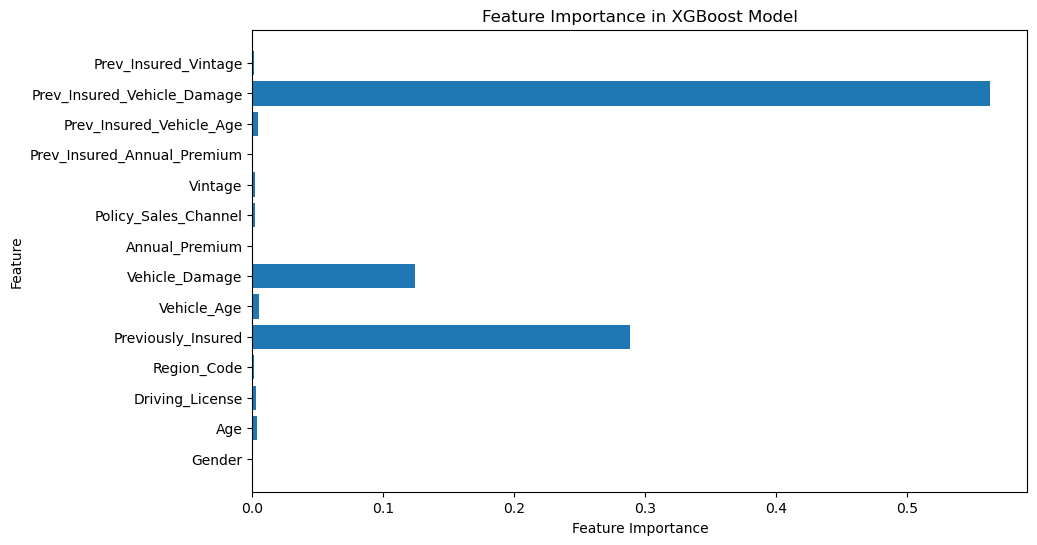

In [53]:
# Feature Importance

feature_importances = best_xgb_random.feature_importances_
features = scaled_x_train.columns

# Plot feature importance

plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in XGBoost Model')
plt.show()

In [54]:
# Define the search space for Bayesian Optimization

space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 300, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 3, 10, 1)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    'subsample': hp.uniform('subsample', 0.8, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.8, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.2),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 1, 10, 1)),
    'reg_alpha': hp.uniform('reg_alpha', 0, 0.1),
    'reg_lambda': hp.uniform('reg_lambda', 1, 2),
    'scale_pos_weight': scope.int(hp.quniform('scale_pos_weight', 1, 3, 1)),
    'max_delta_step': scope.int(hp.quniform('max_delta_step', 0, 10, 1)),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.8, 1.0),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.8, 1.0)
}

def objective(params):
    logger.info(f"Training with params: {params}")
    
    clf = xgb.XGBClassifier(
        n_estimators = int(params['n_estimators']),
        max_depth = int(params['max_depth']),
        learning_rate = params['learning_rate'],
        subsample=params['subsample'],
        colsample_bytree = params['colsample_bytree'],
        gamma=params['gamma'],
        min_child_weight = params['min_child_weight'],
        reg_alpha = params['reg_alpha'],
        reg_lambda = params['reg_lambda'],
        scale_pos_weight = params['scale_pos_weight'],
        max_delta_step = params['max_delta_step'],
        colsample_bylevel = params['colsample_bylevel'],
        colsample_bynode = params['colsample_bynode'],
        random_state = 42,
        use_label_encoder = False,
        eval_metric = 'logloss',
        n_jobs = -1
    )
    
    kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    roc_auc = make_scorer(roc_auc_score, needs_proba = True)
    score = cross_val_score(clf, scaled_x_train, scaled_y_train, cv = kfold, scoring = roc_auc, n_jobs = -1).mean()
    
    return {'loss': -score, 'status': STATUS_OK}

trials = Trials()

In [57]:
logger.info("Starting Bayesian optimization")
start_time = time.time()
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials, 
            rstate = np.random.default_rng(42))
logger.info(f"Bayesian optimization completed. Time elapsed: {time.time() - start_time:.2f} seconds")

logger.info(f"Best hyperparameters: {best}")

INFO:__main__:Starting Bayesian optimization


  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003709 seconds
INFO:hyperopt.tpe:TPE using 0 trials
INFO:__main__:Training with params: {'colsample_bylevel': 0.8054836379051529, 'colsample_bynode': 0.8121669674222713, 'colsample_bytree': 0.8171849044142304, 'gamma': 0.19797675996200848, 'learning_rate': 0.0535766415254642, 'max_delta_step': 3, 'max_depth': 8, 'min_child_weight': 2, 'n_estimators': 254, 'reg_alpha': 0.0651742399748894, 'reg_lambda': 1.8839266254726155, 'scale_pos_weight': 2, 'subsample': 0.9627310815280575}


  2%|▏         | 1/50 [15:04<12:18:34, 904.38s/trial, best loss: -0.8789129150011702]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -0.878913
INFO:__main__:Training with params: {'colsample_bylevel': 0.9680083197412719, 'colsample_bynode': 0.974304608694341, 'colsample_bytree': 0.8700479483097595, 'gamma': 0.04172575399395109, 'learning_rate': 0.04076853734551276, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 2, 'n_estimators': 213, 'reg_alpha': 0.005993618908140053, 'reg_lambda': 1.8609304819134347, 'scale_pos_weight': 2, 'subsample': 0.8600842709581017}


  4%|▍         | 2/50 [29:52<11:56:01, 895.03s/trial, best loss: -0.8789129150011702]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -0.878913
INFO:__main__:Training with params: {'colsample_bylevel': 0.8448706813915479, 'colsample_bynode': 0.9280133586316258, 'colsample_bytree': 0.8567763159374832, 'gamma': 0.0780141313548821, 'learning_rate': 0.06993434789308055, 'max_delta_step': 5, 'max_depth': 9, 'min_child_weight': 8, 'n_estimators': 215, 'reg_alpha': 0.015717970056189714, 'reg_lambda': 1.617660851273003, 'scale_pos_weight': 1, 'subsample': 0.8293925574570056}


  6%|▌         | 3/50 [44:50<11:42:06, 896.32s/trial, best loss: -0.8808260486398096]

INFO:hyperopt.tpe:build_posterior_wrapper took 1.144756 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -0.880826
INFO:__main__:Training with params: {'colsample_bylevel': 0.9090033866538327, 'colsample_bynode': 0.8324683496772729, 'colsample_bytree': 0.9965156272842887, 'gamma': 0.036456555222515785, 'learning_rate': 0.03271807049456165, 'max_delta_step': 6, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 115, 'reg_alpha': 0.07044600162750468, 'reg_lambda': 1.5924534133258075, 'scale_pos_weight': 1, 'subsample': 0.8807555340523958}


  8%|▊         | 4/50 [51:02<8:48:19, 689.13s/trial, best loss: -0.8808260486398096] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.015622 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -0.880826
INFO:__main__:Training with params: {'colsample_bylevel': 0.8428331303366521, 'colsample_bynode': 0.9616151600567981, 'colsample_bytree': 0.9220458763874418, 'gamma': 0.03280291925601153, 'learning_rate': 0.07104863970531992, 'max_delta_step': 8, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 168, 'reg_alpha': 0.03461185976345021, 'reg_lambda': 1.2873563198532338, 'scale_pos_weight': 1, 'subsample': 0.9005807509322964}


 10%|█         | 5/50 [1:01:09<8:14:35, 659.46s/trial, best loss: -0.8808260486398096]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -0.880826
INFO:__main__:Training with params: {'colsample_bylevel': 0.9290896807161692, 'colsample_bynode': 0.9381108822343714, 'colsample_bytree': 0.921853897425303, 'gamma': 0.014486997217175168, 'learning_rate': 0.0871584499486016, 'max_delta_step': 9, 'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 281, 'reg_alpha': 0.07231479244442288, 'reg_lambda': 1.4419433983524534, 'scale_pos_weight': 1, 'subsample': 0.9509454720529578}


 12%|█▏        | 6/50 [1:15:37<8:55:37, 730.41s/trial, best loss: -0.8808260486398096]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008852 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -0.880826
INFO:__main__:Training with params: {'colsample_bylevel': 0.8670242794358931, 'colsample_bynode': 0.9393887142981345, 'colsample_bytree': 0.8111609382128321, 'gamma': 0.12380451226366387, 'learning_rate': 0.04884317212333361, 'max_delta_step': 1, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 201, 'reg_alpha': 0.0869355916285306, 'reg_lambda': 1.0817469419521557, 'scale_pos_weight': 3, 'subsample': 0.9398157189483016}


 14%|█▍        | 7/50 [1:24:26<7:56:27, 664.82s/trial, best loss: -0.8808260486398096]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011370 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -0.880826
INFO:__main__:Training with params: {'colsample_bylevel': 0.9653198432071706, 'colsample_bynode': 0.8026349652824348, 'colsample_bytree': 0.8191717438171058, 'gamma': 0.14421948207253418, 'learning_rate': 0.0921548370606838, 'max_delta_step': 3, 'max_depth': 8, 'min_child_weight': 8, 'n_estimators': 128, 'reg_alpha': 0.03369797392451083, 'reg_lambda': 1.7480357729604008, 'scale_pos_weight': 3, 'subsample': 0.8128573726619099}


 16%|█▌        | 8/50 [1:33:00<7:11:44, 616.77s/trial, best loss: -0.8808260486398096]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.015627 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -0.880826
INFO:__main__:Training with params: {'colsample_bylevel': 0.9289943086342253, 'colsample_bynode': 0.9143465942770092, 'colsample_bytree': 0.8227193021843384, 'gamma': 0.15223681771282743, 'learning_rate': 0.04413586612258082, 'max_delta_step': 8, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 299, 'reg_alpha': 0.05734609694174653, 'reg_lambda': 1.054077874444184, 'scale_pos_weight': 3, 'subsample': 0.9446596807348722}


 18%|█▊        | 9/50 [1:48:27<8:07:41, 713.71s/trial, best loss: -0.8808260486398096]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -0.880826
INFO:__main__:Training with params: {'colsample_bylevel': 0.8257283275048358, 'colsample_bynode': 0.8126795697550439, 'colsample_bytree': 0.9359336090425244, 'gamma': 0.12347718994820872, 'learning_rate': 0.055400412706940586, 'max_delta_step': 1, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 231, 'reg_alpha': 0.07041340569061305, 'reg_lambda': 1.4349979536508064, 'scale_pos_weight': 2, 'subsample': 0.8650064785470949}


 20%|██        | 10/50 [2:00:19<7:55:28, 713.22s/trial, best loss: -0.8808260486398096]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.017313 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -0.880826
INFO:__main__:Training with params: {'colsample_bylevel': 0.9076036465262284, 'colsample_bynode': 0.9075568042761829, 'colsample_bytree': 0.8775275344020654, 'gamma': 0.12112989732349873, 'learning_rate': 0.05580216681127196, 'max_delta_step': 3, 'max_depth': 9, 'min_child_weight': 6, 'n_estimators': 290, 'reg_alpha': 0.09547804466890908, 'reg_lambda': 1.2683247537105375, 'scale_pos_weight': 1, 'subsample': 0.806940687171364}


 22%|██▏       | 11/50 [2:20:04<9:17:16, 857.35s/trial, best loss: -0.8814563072956115]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009338 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -0.881456
INFO:__main__:Training with params: {'colsample_bylevel': 0.8518251830824531, 'colsample_bynode': 0.802240135260987, 'colsample_bytree': 0.8437755535257347, 'gamma': 0.09416592060002325, 'learning_rate': 0.02828222155804326, 'max_delta_step': 9, 'max_depth': 7, 'min_child_weight': 10, 'n_estimators': 151, 'reg_alpha': 0.030780459889893877, 'reg_lambda': 1.1048306170464686, 'scale_pos_weight': 2, 'subsample': 0.9562175667327782}


 24%|██▍       | 12/50 [2:29:55<8:11:44, 776.43s/trial, best loss: -0.8814563072956115]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -0.881456
INFO:__main__:Training with params: {'colsample_bylevel': 0.8199628751047784, 'colsample_bynode': 0.8795994128731556, 'colsample_bytree': 0.8960647984926461, 'gamma': 0.1123271170669171, 'learning_rate': 0.06510746320039981, 'max_delta_step': 2, 'max_depth': 7, 'min_child_weight': 6, 'n_estimators': 262, 'reg_alpha': 0.02168696758570743, 'reg_lambda': 1.6091041490883193, 'scale_pos_weight': 2, 'subsample': 0.856632187606021}


 26%|██▌       | 13/50 [2:45:52<8:32:30, 831.11s/trial, best loss: -0.8814563072956115]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006610 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -0.881456
INFO:__main__:Training with params: {'colsample_bylevel': 0.8780399315986481, 'colsample_bynode': 0.8888596499187903, 'colsample_bytree': 0.8141231178034963, 'gamma': 0.11298328334095316, 'learning_rate': 0.03746522025585301, 'max_delta_step': 7, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 252, 'reg_alpha': 0.08820998106981125, 'reg_lambda': 1.0888518480658376, 'scale_pos_weight': 2, 'subsample': 0.8134845847588219}


 28%|██▊       | 14/50 [3:01:39<8:39:40, 866.13s/trial, best loss: -0.8814563072956115]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -0.881456
INFO:__main__:Training with params: {'colsample_bylevel': 0.9486798864038022, 'colsample_bynode': 0.8025146933947283, 'colsample_bytree': 0.8747303772048436, 'gamma': 0.16301539362279174, 'learning_rate': 0.04983215776856075, 'max_delta_step': 4, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 122, 'reg_alpha': 0.09739479466464523, 'reg_lambda': 1.0170966899477445, 'scale_pos_weight': 3, 'subsample': 0.8464921274939194}


 30%|███       | 15/50 [3:09:56<7:20:18, 754.82s/trial, best loss: -0.8814563072956115]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008282 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -0.881456
INFO:__main__:Training with params: {'colsample_bylevel': 0.8001191155462385, 'colsample_bynode': 0.8117855581121773, 'colsample_bytree': 0.9777546884326647, 'gamma': 0.13009039431089195, 'learning_rate': 0.024239251180413257, 'max_delta_step': 9, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 271, 'reg_alpha': 0.0334860094388081, 'reg_lambda': 1.2042842520101622, 'scale_pos_weight': 3, 'subsample': 0.9750495218298295}


 32%|███▏      | 16/50 [3:27:05<7:54:35, 837.51s/trial, best loss: -0.8814563072956115]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008371 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -0.881456
INFO:__main__:Training with params: {'colsample_bylevel': 0.9747221068601384, 'colsample_bynode': 0.9622196226159235, 'colsample_bytree': 0.9651508162983583, 'gamma': 0.0284254901758096, 'learning_rate': 0.029216327395551668, 'max_delta_step': 3, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 162, 'reg_alpha': 0.0451625695847095, 'reg_lambda': 1.816994764213365, 'scale_pos_weight': 3, 'subsample': 0.9764535209949264}


 34%|███▍      | 17/50 [3:34:55<6:39:52, 727.05s/trial, best loss: -0.8814563072956115]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.020667 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -0.881456
INFO:__main__:Training with params: {'colsample_bylevel': 0.8934870180069071, 'colsample_bynode': 0.965585758186855, 'colsample_bytree': 0.9513340619573141, 'gamma': 0.1796851816508074, 'learning_rate': 0.036951406092650046, 'max_delta_step': 1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 129, 'reg_alpha': 0.0976525304162185, 'reg_lambda': 1.3506832932733328, 'scale_pos_weight': 1, 'subsample': 0.864989806272622}


 36%|███▌      | 18/50 [3:42:09<5:40:48, 639.01s/trial, best loss: -0.8814563072956115]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009106 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -0.881456
INFO:__main__:Training with params: {'colsample_bylevel': 0.9270408269843368, 'colsample_bynode': 0.9638785130826996, 'colsample_bytree': 0.8917569993698322, 'gamma': 0.12254261187601544, 'learning_rate': 0.09864794881928264, 'max_delta_step': 9, 'max_depth': 8, 'min_child_weight': 7, 'n_estimators': 170, 'reg_alpha': 0.041716268818537364, 'reg_lambda': 1.1280768959263718, 'scale_pos_weight': 3, 'subsample': 0.8490427097761732}


 38%|███▊      | 19/50 [3:53:26<5:35:58, 650.26s/trial, best loss: -0.8814563072956115]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006009 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -0.881456
INFO:__main__:Training with params: {'colsample_bylevel': 0.8372175323527669, 'colsample_bynode': 0.9552552773377125, 'colsample_bytree': 0.8206918155181429, 'gamma': 0.09313585505940654, 'learning_rate': 0.027737996326976495, 'max_delta_step': 3, 'max_depth': 8, 'min_child_weight': 6, 'n_estimators': 152, 'reg_alpha': 0.02298357960090034, 'reg_lambda': 1.9759998977389168, 'scale_pos_weight': 2, 'subsample': 0.8894647189973964}


 40%|████      | 20/50 [4:03:55<5:21:56, 643.88s/trial, best loss: -0.8814563072956115]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004010 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -0.881456
INFO:__main__:Training with params: {'colsample_bylevel': 0.9938745825050959, 'colsample_bynode': 0.9963665823189598, 'colsample_bytree': 0.8512175430869154, 'gamma': 0.06542458743359815, 'learning_rate': 0.07778638366290973, 'max_delta_step': 6, 'max_depth': 10, 'min_child_weight': 9, 'n_estimators': 231, 'reg_alpha': 0.009172510635295332, 'reg_lambda': 1.6084470073571417, 'scale_pos_weight': 1, 'subsample': 0.8012519398309906}


 42%|████▏     | 21/50 [4:20:31<6:02:16, 749.55s/trial, best loss: -0.8827266731769218]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007737 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -0.882727
INFO:__main__:Training with params: {'colsample_bylevel': 0.992383777755151, 'colsample_bynode': 0.9947198511655564, 'colsample_bytree': 0.8558090208281949, 'gamma': 0.07193320516849086, 'learning_rate': 0.07559670637685854, 'max_delta_step': 5, 'max_depth': 10, 'min_child_weight': 9, 'n_estimators': 298, 'reg_alpha': 0.00011604186976933197, 'reg_lambda': 1.5297016337780345, 'scale_pos_weight': 1, 'subsample': 0.8013942234890727}


 44%|████▍     | 22/50 [4:41:18<6:59:29, 898.90s/trial, best loss: -0.8837316798370821]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -0.883732
INFO:__main__:Training with params: {'colsample_bylevel': 0.9940025289834439, 'colsample_bynode': 0.9956460011539063, 'colsample_bytree': 0.8448166324869208, 'gamma': 0.06460309841429338, 'learning_rate': 0.0812811671412472, 'max_delta_step': 6, 'max_depth': 10, 'min_child_weight': 9, 'n_estimators': 240, 'reg_alpha': 6.064669106507649e-05, 'reg_lambda': 1.7080407450144357, 'scale_pos_weight': 1, 'subsample': 0.800061120928926}


 46%|████▌     | 23/50 [4:58:20<7:01:09, 935.90s/trial, best loss: -0.8837316798370821]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.022236 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -0.883732
INFO:__main__:Training with params: {'colsample_bylevel': 0.9927998815090168, 'colsample_bynode': 0.9970396943261006, 'colsample_bytree': 0.8391044260739025, 'gamma': 0.05944978171209169, 'learning_rate': 0.08240755390422617, 'max_delta_step': 5, 'max_depth': 10, 'min_child_weight': 9, 'n_estimators': 233, 'reg_alpha': 0.006521544998903575, 'reg_lambda': 1.728634932661966, 'scale_pos_weight': 1, 'subsample': 0.9147662106538639}


 48%|████▊     | 24/50 [5:14:52<6:52:46, 952.56s/trial, best loss: -0.8837316798370821]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -0.883732
INFO:__main__:Training with params: {'colsample_bylevel': 0.9951929930551984, 'colsample_bynode': 0.9897401686365959, 'colsample_bytree': 0.8010665164356681, 'gamma': 0.07140222781940667, 'learning_rate': 0.09963346243555755, 'max_delta_step': 6, 'max_depth': 10, 'min_child_weight': 9, 'n_estimators': 297, 'reg_alpha': 0.0022293880023777244, 'reg_lambda': 1.5050229982288488, 'scale_pos_weight': 1, 'subsample': 0.8302721292642807}


 50%|█████     | 25/50 [5:35:17<7:11:02, 1034.49s/trial, best loss: -0.8847688114569354]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.022549 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -0.884769
INFO:__main__:Training with params: {'colsample_bylevel': 0.9512150023380905, 'colsample_bynode': 0.8640411050662586, 'colsample_bytree': 0.832737711886373, 'gamma': 0.08165163820481439, 'learning_rate': 0.010472100665649423, 'max_delta_step': 7, 'max_depth': 9, 'min_child_weight': 8, 'n_estimators': 296, 'reg_alpha': 0.016114959444923208, 'reg_lambda': 1.5045001364341375, 'scale_pos_weight': 1, 'subsample': 0.8298226383118629}


 52%|█████▏    | 26/50 [5:55:25<7:14:34, 1086.42s/trial, best loss: -0.8847688114569354]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008015 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -0.884769
INFO:__main__:Training with params: {'colsample_bylevel': 0.9846040141717401, 'colsample_bynode': 0.9822685233856282, 'colsample_bytree': 0.8011267116321672, 'gamma': 0.005780057506201072, 'learning_rate': 0.09885577982050103, 'max_delta_step': 4, 'max_depth': 10, 'min_child_weight': 10, 'n_estimators': 277, 'reg_alpha': 0.0016565923514728013, 'reg_lambda': 1.5146811619445368, 'scale_pos_weight': 1, 'subsample': 0.9996138233445439}


 54%|█████▍    | 27/50 [6:14:11<7:01:04, 1098.46s/trial, best loss: -0.8847688114569354]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008487 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -0.884769
INFO:__main__:Training with params: {'colsample_bylevel': 0.9794047724869411, 'colsample_bynode': 0.9782397415695917, 'colsample_bytree': 0.8016253183973637, 'gamma': 0.0018350502185415785, 'learning_rate': 0.09961451255881067, 'max_delta_step': 4, 'max_depth': 9, 'min_child_weight': 10, 'n_estimators': 278, 'reg_alpha': 0.02423208673066902, 'reg_lambda': 1.393488511761001, 'scale_pos_weight': 1, 'subsample': 0.9970804829928148}


 56%|█████▌    | 28/50 [6:32:06<6:40:06, 1091.18s/trial, best loss: -0.8847688114569354]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007320 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -0.884769
INFO:__main__:Training with params: {'colsample_bylevel': 0.9524399210717543, 'colsample_bynode': 0.9824429053294425, 'colsample_bytree': 0.8018678784582168, 'gamma': 0.005736573740481851, 'learning_rate': 0.09256187965150274, 'max_delta_step': 4, 'max_depth': 10, 'min_child_weight': 10, 'n_estimators': 252, 'reg_alpha': 0.057013824516909214, 'reg_lambda': 1.965766974518735, 'scale_pos_weight': 1, 'subsample': 0.9210350784455286}


 58%|█████▊    | 29/50 [6:49:37<6:17:44, 1079.28s/trial, best loss: -0.8847688114569354]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.021639 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -0.884769
INFO:__main__:Training with params: {'colsample_bylevel': 0.9814467942132015, 'colsample_bynode': 0.946052246265932, 'colsample_bytree': 0.8306571536609062, 'gamma': 0.050232986537291704, 'learning_rate': 0.09974470807278782, 'max_delta_step': 7, 'max_depth': 8, 'min_child_weight': 7, 'n_estimators': 190, 'reg_alpha': 0.011305096622596943, 'reg_lambda': 1.3288814092782362, 'scale_pos_weight': 2, 'subsample': 0.9971488043244778}


 60%|██████    | 30/50 [7:01:50<5:25:04, 975.21s/trial, best loss: -0.8847688114569354] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007535 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -0.884769
INFO:__main__:Training with params: {'colsample_bylevel': 0.9610804028142429, 'colsample_bynode': 0.9206783535323841, 'colsample_bytree': 0.8025899231700232, 'gamma': 0.0166602705154395, 'learning_rate': 0.06278401127657816, 'max_delta_step': 2, 'max_depth': 9, 'min_child_weight': 8, 'n_estimators': 271, 'reg_alpha': 0.0011872107133071644, 'reg_lambda': 1.6661922694616846, 'scale_pos_weight': 1, 'subsample': 0.9284604403458695}


 62%|██████▏   | 31/50 [7:20:00<5:19:43, 1009.66s/trial, best loss: -0.8847688114569354]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -0.884769
INFO:__main__:Training with params: {'colsample_bylevel': 0.9382564227228236, 'colsample_bynode': 0.8436503738394279, 'colsample_bytree': 0.8860902251963142, 'gamma': 0.04579601668538248, 'learning_rate': 0.09239757671286818, 'max_delta_step': 6, 'max_depth': 6, 'min_child_weight': 9, 'n_estimators': 288, 'reg_alpha': 0.01894918324832194, 'reg_lambda': 1.5367790071711878, 'scale_pos_weight': 1, 'subsample': 0.8286688017846673}


 64%|██████▍   | 32/50 [7:35:50<4:57:31, 991.75s/trial, best loss: -0.8847688114569354] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006947 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -0.884769
INFO:__main__:Training with params: {'colsample_bylevel': 0.9172174927593002, 'colsample_bynode': 0.9824532968155417, 'colsample_bytree': 0.9083063493707201, 'gamma': 0.18562240351297332, 'learning_rate': 0.01557316076530476, 'max_delta_step': 4, 'max_depth': 9, 'min_child_weight': 10, 'n_estimators': 216, 'reg_alpha': 0.01311117695907518, 'reg_lambda': 1.8220646913715848, 'scale_pos_weight': 1, 'subsample': 0.8796949044157725}


 66%|██████▌   | 33/50 [7:50:44<4:32:45, 962.70s/trial, best loss: -0.8847688114569354]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005920 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -0.884769
INFO:__main__:Training with params: {'colsample_bylevel': 0.8867768212300718, 'colsample_bynode': 0.9277803149036712, 'colsample_bytree': 0.997906024982279, 'gamma': 0.022550851501047298, 'learning_rate': 0.08694229661189311, 'max_delta_step': 2, 'max_depth': 10, 'min_child_weight': 8, 'n_estimators': 264, 'reg_alpha': 0.004664773074411452, 'reg_lambda': 1.4490472877516434, 'scale_pos_weight': 2, 'subsample': 0.9816438360464115}


 68%|██████▊   | 34/50 [8:09:22<4:29:08, 1009.29s/trial, best loss: -0.8847688114569354]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010169 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -0.884769
INFO:__main__:Training with params: {'colsample_bylevel': 0.9992115201109536, 'colsample_bynode': 0.9492508189826617, 'colsample_bytree': 0.8681513443636177, 'gamma': 0.08309851581243347, 'learning_rate': 0.07019705070857309, 'max_delta_step': 10, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 103, 'reg_alpha': 0.04372207221487896, 'reg_lambda': 1.225979802144744, 'scale_pos_weight': 1, 'subsample': 0.9001774309861903}


 70%|███████   | 35/50 [8:16:40<3:29:28, 837.91s/trial, best loss: -0.8847688114569354] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003869 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -0.884769
INFO:__main__:Training with params: {'colsample_bylevel': 0.9803488670866392, 'colsample_bynode': 0.8943441843308484, 'colsample_bytree': 0.8624692642020961, 'gamma': 0.05076331540130886, 'learning_rate': 0.0944632403072419, 'max_delta_step': 8, 'max_depth': 9, 'min_child_weight': 7, 'n_estimators': 186, 'reg_alpha': 0.026248566940524586, 'reg_lambda': 1.655871421128171, 'scale_pos_weight': 1, 'subsample': 0.8327272441574796}


 72%|███████▏  | 36/50 [8:29:37<3:11:13, 819.52s/trial, best loss: -0.8847688114569354]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006588 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -0.884769
INFO:__main__:Training with params: {'colsample_bylevel': 0.9653942711417073, 'colsample_bynode': 0.972152076713888, 'colsample_bytree': 0.9055530034407975, 'gamma': 0.035929468118200004, 'learning_rate': 0.087047322252663, 'max_delta_step': 5, 'max_depth': 3, 'min_child_weight': 9, 'n_estimators': 217, 'reg_alpha': 0.0063393614649352005, 'reg_lambda': 1.567558576893128, 'scale_pos_weight': 2, 'subsample': 0.910364321306788}


 74%|███████▍  | 37/50 [8:39:26<2:42:34, 750.33s/trial, best loss: -0.8847688114569354]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008876 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -0.884769
INFO:__main__:Training with params: {'colsample_bylevel': 0.9373128475246145, 'colsample_bynode': 0.9330488219622443, 'colsample_bytree': 0.8110953600993275, 'gamma': 0.009438557040050616, 'learning_rate': 0.06142735883661578, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 10, 'n_estimators': 243, 'reg_alpha': 0.05590103370517257, 'reg_lambda': 1.897211825412946, 'scale_pos_weight': 1, 'subsample': 0.8768783844898927}


 76%|███████▌  | 38/50 [8:53:09<2:34:26, 772.22s/trial, best loss: -0.8847688114569354]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -0.884769
INFO:__main__:Training with params: {'colsample_bylevel': 0.8621499655149234, 'colsample_bynode': 0.8678035878543849, 'colsample_bytree': 0.8321573294943867, 'gamma': 0.10405737438935794, 'learning_rate': 0.09601390155433229, 'max_delta_step': 6, 'max_depth': 4, 'min_child_weight': 8, 'n_estimators': 202, 'reg_alpha': 0.03896941088246951, 'reg_lambda': 1.4784528409116244, 'scale_pos_weight': 1, 'subsample': 0.9375384901655378}


 78%|███████▊  | 39/50 [9:03:03<2:11:44, 718.58s/trial, best loss: -0.8847688114569354]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006758 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -0.884769
INFO:__main__:Training with params: {'colsample_bylevel': 0.9168027504689348, 'colsample_bynode': 0.9053200299093824, 'colsample_bytree': 0.9168325745505281, 'gamma': 0.025393199383345038, 'learning_rate': 0.07576434333263643, 'max_delta_step': 7, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 281, 'reg_alpha': 0.0648767859796822, 'reg_lambda': 1.3882897941597099, 'scale_pos_weight': 2, 'subsample': 0.9635782824147745}


 80%|████████  | 40/50 [9:22:49<2:23:08, 858.85s/trial, best loss: -0.8847688114569354]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005780 seconds
INFO:hyperopt.tpe:TPE using 40/40 trials with best loss -0.884769
INFO:__main__:Training with params: {'colsample_bylevel': 0.9716978000763337, 'colsample_bynode': 0.9865579859008884, 'colsample_bytree': 0.9297528069481966, 'gamma': 0.13922289666364018, 'learning_rate': 0.08271535009446711, 'max_delta_step': 5, 'max_depth': 9, 'min_child_weight': 7, 'n_estimators': 260, 'reg_alpha': 0.028610646646460913, 'reg_lambda': 1.7784142646227894, 'scale_pos_weight': 1, 'subsample': 0.986285781695207}


 82%|████████▏ | 41/50 [9:40:01<2:16:38, 910.92s/trial, best loss: -0.8847688114569354]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001946 seconds
INFO:hyperopt.tpe:TPE using 41/41 trials with best loss -0.884769
INFO:__main__:Training with params: {'colsample_bylevel': 0.9582756556421229, 'colsample_bynode': 0.8457232651508745, 'colsample_bytree': 0.8094828542925135, 'gamma': 0.1975593823036172, 'learning_rate': 0.08871702494558957, 'max_delta_step': 4, 'max_depth': 10, 'min_child_weight': 10, 'n_estimators': 300, 'reg_alpha': 0.07952181286181949, 'reg_lambda': 1.17390552678416, 'scale_pos_weight': 1, 'subsample': 0.8889603533219529}


 84%|████████▍ | 42/50 [10:01:08<2:15:41, 1017.67s/trial, best loss: -0.8847688114569354]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006059 seconds
INFO:hyperopt.tpe:TPE using 42/42 trials with best loss -0.884769
INFO:__main__:Training with params: {'colsample_bylevel': 0.9860594901116136, 'colsample_bynode': 0.9496326518743733, 'colsample_bytree': 0.8813558243653479, 'gamma': 0.1643337196131277, 'learning_rate': 0.06738715707876047, 'max_delta_step': 8, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 287, 'reg_alpha': 0.018084284799897325, 'reg_lambda': 1.6760811172522967, 'scale_pos_weight': 2, 'subsample': 0.8403585993717717}


 86%|████████▌ | 43/50 [10:20:22<2:03:30, 1058.67s/trial, best loss: -0.8847688114569354]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008265 seconds
INFO:hyperopt.tpe:TPE using 43/43 trials with best loss -0.884769
INFO:__main__:Training with params: {'colsample_bylevel': 0.9426306142578034, 'colsample_bynode': 0.9734706657835591, 'colsample_bytree': 0.8233549300321228, 'gamma': 0.03938114781867094, 'learning_rate': 0.05986414632898069, 'max_delta_step': 3, 'max_depth': 8, 'min_child_weight': 4, 'n_estimators': 273, 'reg_alpha': 0.012684129156641792, 'reg_lambda': 1.3248543481283563, 'scale_pos_weight': 1, 'subsample': 0.8171441537170424}


 88%|████████▊ | 44/50 [10:37:55<1:45:40, 1056.83s/trial, best loss: -0.8847688114569354]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 44/44 trials with best loss -0.884769
INFO:__main__:Training with params: {'colsample_bylevel': 0.999925444726354, 'colsample_bynode': 0.9180794950706361, 'colsample_bytree': 0.9832168878780598, 'gamma': 0.09074668148331753, 'learning_rate': 0.07245594705274824, 'max_delta_step': 10, 'max_depth': 6, 'min_child_weight': 8, 'n_estimators': 222, 'reg_alpha': 0.05012016468613005, 'reg_lambda': 1.5606332830521297, 'scale_pos_weight': 2, 'subsample': 0.9613151996368025}


 90%|█████████ | 45/50 [10:50:26<1:20:26, 965.21s/trial, best loss: -0.8847688114569354] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009718 seconds
INFO:hyperopt.tpe:TPE using 45/45 trials with best loss -0.884769
INFO:__main__:Training with params: {'colsample_bylevel': 0.8125348394261872, 'colsample_bynode': 0.9396425902881241, 'colsample_bytree': 0.9392936813766851, 'gamma': 0.10533472466891158, 'learning_rate': 0.04448045409482684, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 9, 'n_estimators': 242, 'reg_alpha': 0.03820001472598233, 'reg_lambda': 1.411515333489573, 'scale_pos_weight': 1, 'subsample': 0.8563260429852556}


 92%|█████████▏| 46/50 [11:02:29<59:30, 892.60s/trial, best loss: -0.8847688114569354]  

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003383 seconds
INFO:hyperopt.tpe:TPE using 46/46 trials with best loss -0.884769
INFO:__main__:Training with params: {'colsample_bylevel': 0.9035812660510947, 'colsample_bynode': 0.8761160328413788, 'colsample_bytree': 0.8651283084523574, 'gamma': 0.058586360450973506, 'learning_rate': 0.05242373699660774, 'max_delta_step': 6, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 255, 'reg_alpha': 0.004113699949154168, 'reg_lambda': 1.268843494839937, 'scale_pos_weight': 2, 'subsample': 0.8190842534901634}


 94%|█████████▍| 47/50 [11:16:07<43:29, 869.99s/trial, best loss: -0.8847688114569354]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008043 seconds
INFO:hyperopt.tpe:TPE using 47/47 trials with best loss -0.884769
INFO:__main__:Training with params: {'colsample_bylevel': 0.923038258063106, 'colsample_bynode': 0.9549687293488919, 'colsample_bytree': 0.8012246259171243, 'gamma': 0.017703922572509266, 'learning_rate': 0.09782752016849615, 'max_delta_step': 7, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 207, 'reg_alpha': 0.049836312616862534, 'reg_lambda': 1.8982596425598541, 'scale_pos_weight': 1, 'subsample': 0.9488775750396784}


 96%|█████████▌| 48/50 [11:29:13<28:09, 844.83s/trial, best loss: -0.8847688114569354]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 48/48 trials with best loss -0.884769
INFO:__main__:Training with params: {'colsample_bylevel': 0.8757051222030665, 'colsample_bynode': 0.9885044207743773, 'colsample_bytree': 0.8482624958282464, 'gamma': 0.0732200058915739, 'learning_rate': 0.07938429736162361, 'max_delta_step': 2, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 187, 'reg_alpha': 0.06593105753717521, 'reg_lambda': 1.4819744193973823, 'scale_pos_weight': 3, 'subsample': 0.8716820316503945}


 98%|█████████▊| 49/50 [11:43:20<14:05, 845.41s/trial, best loss: -0.8847688114569354]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006909 seconds
INFO:hyperopt.tpe:TPE using 49/49 trials with best loss -0.884769
INFO:__main__:Training with params: {'colsample_bylevel': 0.8960252124135056, 'colsample_bynode': 0.9699203386728714, 'colsample_bytree': 0.8390052869658012, 'gamma': 0.1534001030794379, 'learning_rate': 0.021584015612730052, 'max_delta_step': 1, 'max_depth': 7, 'min_child_weight': 6, 'n_estimators': 137, 'reg_alpha': 0.0800074279982177, 'reg_lambda': 1.6404334056706726, 'scale_pos_weight': 1, 'subsample': 0.9329562461527197}


100%|██████████| 50/50 [11:51:48<00:00, 854.17s/trial, best loss: -0.8847688114569354]

INFO:__main__:Bayesian optimization completed. Time elapsed: 42708.51 seconds
INFO:__main__:Best hyperparameters: {'colsample_bylevel': 0.9951929930551984, 'colsample_bynode': 0.9897401686365959, 'colsample_bytree': 0.8010665164356681, 'gamma': 0.07140222781940667, 'learning_rate': 0.09963346243555755, 'max_delta_step': 6.0, 'max_depth': 10.0, 'min_child_weight': 9.0, 'n_estimators': 297.0, 'reg_alpha': 0.0022293880023777244, 'reg_lambda': 1.5050229982288488, 'scale_pos_weight': 1.0, 'subsample': 0.8302721292642807}


In [58]:
# Train the final model with the best hyperparameters from Bayesian Optimization

best_xgb_bayes = XGBClassifier(
    n_estimators = int(best['n_estimators']),
    max_depth = int(best['max_depth']),
    learning_rate = best['learning_rate'],
    subsample = best['subsample'],
    colsample_bytree = best['colsample_bytree'],
    gamma = best['gamma'],
    min_child_weight = int(best['min_child_weight']),
    reg_alpha = best['reg_alpha'],
    reg_lambda = best['reg_lambda'],
    scale_pos_weight = int(best['scale_pos_weight']),
    max_delta_step = int(best['max_delta_step']),
    colsample_bylevel = best['colsample_bylevel'],
    colsample_bynode = best['colsample_bynode'],
    random_state = 42,
    use_label_encoder = False,
    eval_metric = 'logloss',
    n_jobs = -1
)

start_time = time.time()
best_xgb_bayes.fit(scaled_x_train, scaled_y_train)
logger.info(f"Final model training completed. Time elapsed: {time.time() - start_time:.2f} seconds")

y_pred_proba_bayes = best_xgb_bayes.predict_proba(scaled_x_val)[:, 1]
test_roc_auc_bayes = roc_auc_score(scaled_y_val, y_pred_proba_bayes)
logger.info(f"Test AUROC Score with Bayesian Optimization: {test_roc_auc_bayes}")


INFO:__main__:Final model training completed. Time elapsed: 360.53 seconds
INFO:__main__:Test AUROC Score with Bayesian Optimization: 0.8579259883847774


In [61]:
best_hyp_bayes = best
best_hyp_random = best_params

In [63]:
best_hyp_random

{'colsample_bylevel': 0.9266807513020847,
 'colsample_bynode': 0.9742921180375436,
 'colsample_bytree': 0.960734415379823,
 'gamma': 0.03731401177720717,
 'learning_rate': 0.09925589984899778,
 'max_delta_step': 9,
 'max_depth': 9,
 'min_child_weight': 9,
 'n_estimators': 289,
 'reg_alpha': 0.011005192452767676,
 'reg_lambda': 1.4558703250838834,
 'scale_pos_weight': 2,
 'subsample': 0.8001040753990633}

In [64]:
best_hyp_bayes

{'colsample_bylevel': 0.9951929930551984,
 'colsample_bynode': 0.9897401686365959,
 'colsample_bytree': 0.8010665164356681,
 'gamma': 0.07140222781940667,
 'learning_rate': 0.09963346243555755,
 'max_delta_step': 6.0,
 'max_depth': 10.0,
 'min_child_weight': 9.0,
 'n_estimators': 297.0,
 'reg_alpha': 0.0022293880023777244,
 'reg_lambda': 1.5050229982288488,
 'scale_pos_weight': 1.0,
 'subsample': 0.8302721292642807}